In [49]:
import pandas as pd
import glob
from itertools import product, combinations
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

## Read in data and plot

In [64]:
logs = glob.glob('outputs/narratives_compare/*')

In [65]:
for i, l in enumerate(logs):
    ldf = pd.read_csv(l, sep='\t', index_col=0)
    if i % 100 == 0:
        print(f'{i} of {len(logs)}')
    if l == logs[0]:
        all_logs = ldf
    else:
        all_logs = pd.concat([all_logs, 
                              ldf], ignore_index=True)
all_logs['is_true'] = (all_logs['target'] == all_logs['top_predicted']).astype(int)
all_logs['surprisal'] = -np.log2(all_logs['prob_true'])
metrics = ['loss', 'is_true', 'surprisal', 'entropy', 'prob_true', 'prob_predicted']
aggs = all_logs.groupby(['case_sensitive', 'model', 
                         'context_size', 'dataset'])[metrics].mean().reset_index()

0 of 151
100 of 151


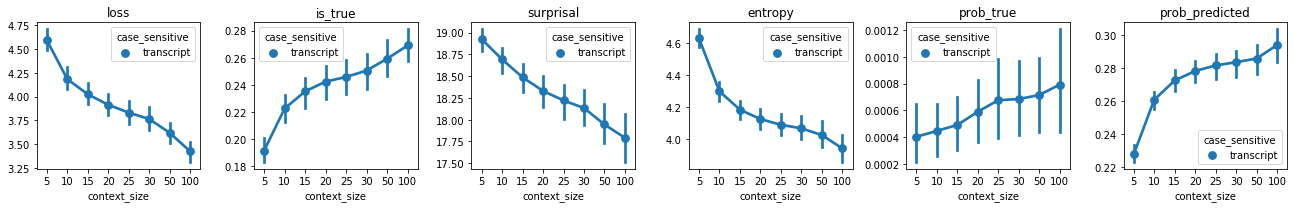

In [66]:
fig, ax = plt.subplots(ncols=6, figsize=(18,3))
for i, m in enumerate(metrics):
    sns.pointplot(data=aggs, 
                  x='context_size', 
                  y=m, 
                  hue='case_sensitive', 
                  ax=ax[i],
                  #palette='RdBu'
                  )
    ax[i].set_title(m)
    ax[i].set_ylabel('')
plt.tight_layout()
plt.show()

In [62]:
all_logs

,dataset,model,context,target,orig_wd,top_predicted,loss,entropy,prob_true,prob_predicted,context_size,case_sensitive,is_true,surprisal
0,santa,gpt2,"""Denny's, It's always open,"" proclaimed Scott ...",the,the,the,2.191254,1.564701,1.659990e-05,0.760224,20,transcript,1,15.878466
1,santa,gpt2,"It's always open,"" proclaimed Scott as he open...",door,"door,",kitchen,0.283798,6.176254,1.832018e-06,0.058049,20,transcript,0,19.058135
2,santa,gpt2,"always open,"" proclaimed Scott as he opened th...",k,kicking,his,1.512295,6.268026,4.658878e-08,0.079967,20,transcript,0,24.355442
3,santa,gpt2,"open,"" proclaimed Scott as he opened the door ...",s,snow,the,8.073412,3.670156,4.028904e-06,0.163735,20,transcript,0,17.921181
4,santa,gpt2,proclaimed Scott as he opened the door to the ...,onto,onto,off,10.244231,2.895367,6.583667e-07,0.454202,20,transcript,0,20.534605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181414,shapessocial,gpt2,to get his ball as his friend gets in position...,they,they,he,1.398605,4.357367,8.362657e-07,0.265671,30,transcript,0,20.189535
181415,shapessocial,gpt2,get his ball as his friend gets in position Th...,had,had,do,3.104526,4.083986,5.461315e-08,0.131812,30,transcript,0,24.126176
181416,shapessocial,gpt2,his ball as his friend gets in position The bo...,in,in,in,3.730025,4.414632,1.242301e-06,0.115594,30,transcript,1,19.618553
181417,shapessocial,gpt2,ball as his friend gets in position The boy ki...,the,the,the,2.017171,4.646028,3.752200e-06,0.292810,30,transcript,1,18.023832
